In [1]:
from dataclasses import dataclass
from observer import CalibratedObserver, TrackedObject, CalibratedCaptureConfiguration, distanceFormula
import dma.MechaCombat as mc
from dma.MechaCombat import GameEvent, GameState, Skill, Mech
QuantumSystem = mc.QuantumSystem
qs = QuantumSystem

In [2]:
@dataclass
class HarmonyObject(TrackedObject):
    oid: str = None
    objectType: str = None
    objectSubType: str = None
    objectKwargs: dict = None

    objectFactories = {"Unit": mc.MechFactories, "Structure": mc.StructureFactories}
    
    def __post_init__(self):
        super().__post_init__()
        print(f"Creating {self.objectType} -- {self.objectSubType} -- {self.objectKwargs}")
        self.objectKwargs = {key.lower(): value for key, value in self.objectKwargs.items()}
        try:
            factory = self.objectFactories[self.objectType][self.objectSubType]
        except KeyError as ke:
            raise Exception(f"Unrecognized object type and subtype - {self.objectType}-{self.objectSubType}")
        self.object = factory(self.oid, faction="Unaligned", **self.objectKwargs)
        GameState.addObject(self.object.entity, self.objectType)

    @classmethod
    def from_tracked_object(cls,
                            trackedObject: TrackedObject,
                            objectType: str,
                            objectSubType: str,
                            objectKwargs: dict):
        # if not qs.entity_exists(trackedObject.oid):
        print(f"Creating {objectType} object from {trackedObject}")
        return cls(
            changeSet=trackedObject.changeSet,
            oid=trackedObject.oid,
            objectType=objectType,
            objectSubType=objectSubType,
            objectKwargs=objectKwargs)
        
    def previousVersion(self):
        return TrackedObject({camName: change.lastChange if change is not None else None for camName, change in self.changeSet.items()})

    def rename(self, newName):
        qs.rename_entity(self.oid, newName)
        self.oid = newName

In [3]:
@dataclass
class ObjectAction:
    actor: HarmonyObject
    target: HarmonyObject
    result: str = "null"
    
    def __post_init__(self):
        assert self.rsc is not None, f"Object Actions require a RealSpace Converter"
        if self.target is None:
            self.targetDistance = None
            self.targetRange = None
            self.rangeModifier = None
            self.objMovement = None
            self.aMM = None
            self.targetMovement = None
            self.tMM = None
            self.skill = None
            self.targetNumber = None
            self.gameEvent = None
            return
        self.targetDistance = self.rsc.distanceBetweenObjects(self.actor, self.target)
        self.targetRange = "short" if self.targetDistance < 155 else "medium" if self.targetDistance < 610 else "long"
        self.rangeModifier = 0 if "short" else 2 if "medium" else 4

        self.objMovement = self.rsc.trackedObjectLastDistance(self.actor)
        self.aMM = -1 if self.objMovement is None or self.objMovement < 10 else 1
        self.targetMovement = self.rsc.trackedObjectLastDistance(self.target)
        self.tMM = -1 if self.targetMovement is None or self.targetMovement < 10 else 1
        self.skill = Skill(self.actor.oid).terminant
        self.targetNumber = int(self.skill) + self.aMM + self.tMM + 0 + self.rangeModifier
        self.gameEvent = None

    def declare(self):
        self.gameEvent = GameEvent.declareEvent("Attack", "Unaligned", self.actor.oid, self.target.oid, self.result)

    def resolve(self, result):
        self.gameEvent.resolve(result)

In [4]:
class HarmonyMachine(CalibratedObserver):
    def reset(self):
        super().reset()
        mc.GameState.reset()
        self.GameState = mc.GameState
        ObjectAction.rsc = self.cc.rsc

    def declareEvent(self, eventType: str, eventFaction: str, eventObject: str, eventValue: str, eventResult: str):
        mc.GameState.declareEvent(eventType, eventFaction, eventObject, eventValue, eventResult)
    
    def classifyObject(self, objectId, objectType, objectSubType, objectKwargs):
        trackedObject = self.findObject(objectId)
        memoryIndex = self.memory.index(trackedObject)
        harmonyObject = HarmonyObject.from_tracked_object(
            trackedObject, objectType, objectSubType, objectKwargs)
        self.memory[memoryIndex] = harmonyObject
        return harmonyObject

    def captureRealCoord(self, capture):
        """ movement distance this round """
        return self.changeSetToRealCenter(capture)

    def captureSystemCoord(self, capture):
        return mc.XYLocation(capture.oid)

    def commitChanges(self, objDef, overwrite=True):
        super().commitChanges(objDef=objDef, overwrite=overwrite)
        if isinstance(objDef, HarmonyObject):
            systemCoord = self.captureSystemCoord(objDef)
            realCoord = self.captureRealCord(objDef)
            delta = [d1 - d0 for d0, d1 in zip(systemCoord, realCoord)]
            delta.append(0)  # TODO: get elevation change from terrain
            if mc.Move.can_move(objDef, delta):
                self.declareEvent(
                    eventType="Move",
                    eventFaction=mc.Faction(objDef.oid),
                    eventObject=objDef.oid,
                    eventValue=json.dumps(delta),
                    eventResult=json.dumps(realCoord))
        return objDef

    def take_action(self, actor, target, result=None):
        return ObjectAction(actor, target, result=result)

    def units_moved_this_round(self):
        mechs = Mech.entities()
        moved = []
        for m in mechs:
            harmonyObject = self.findObject(m.entity)
            if self.cc.rsc.trackedObjectLastDistance(harmonyObject) > 10:
                moved.append(m)
        return moved

Starting Cycle     0 -- CapMac -- passive idle


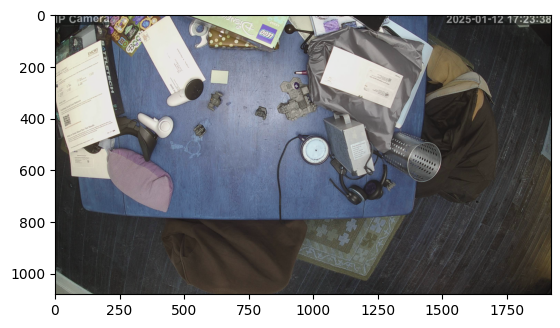

In [5]:
if __name__ == "__main__":
    from matplotlib import pyplot as plt
    cc = CalibratedCaptureConfiguration()
    hm = HarmonyMachine(cc)
    hm.cycle()
    plt.imshow(cc.cameras['0'].mostRecentFrame)

Starting Cycle     1 -- CapMac -- track idle
Starting Cycle     2 -- CapMac -- track idle
Starting Cycle     3 -- CapMac -- track idle
Starting Cycle     4 -- CapMac -- track idle
Starting Cycle     5 -- CapMac -- track idle
Starting Cycle     6 -- CapMac -- track idle
Starting Cycle     7 -- CapMac -- track idle
Starting Cycle     8 -- CapMac -- track idle
Starting Cycle     9 -- CapMac -- track unstable
Starting Cycle    10 -- CapMac -- track classify
Starting Cycle    11 -- CapMac -- track unstable
Starting Cycle    12 -- CapMac -- track classify
Starting Cycle    13 -- CapMac -- track unstable
Starting Cycle    14 -- CapMac -- track classify
Starting Cycle    15 -- CapMac -- track unstable
Starting Cycle    16 -- CapMac -- track unstable
Starting Cycle    17 -- CapMac -- track classify
New Memory
Starting Cycle    18 -- CapMac -- idle idle
Starting Cycle    19 -- CapMac -- idle idle
Starting Cycle    20 -- CapMac -- idle idle


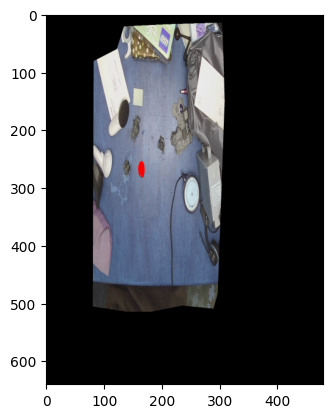

In [6]:
if __name__ == "__main__":
    for i in range(1):
        hm.cycleForChange()
    for i in range(3):
        hm.cycle()
    plt.imshow(hm.getCameraImagesWithChanges()['0'])